# Train the contender on self-play episodes of the champion

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from alphazero.mcts import MCTS
from alphazero.coach import Coach
from alphazero.gomoku_game import GomokuGame as Gomoku, initial_stones
from alphazero.interfaces import TrainParams
from domoku.policies.heuristic_policy import HeuristicPolicy
from alphazero.gomoku_model import NeuralNetAdapter
from alphazero.gomoku_board import GomokuBoard
from domoku import tools as gt

In [3]:
BOARD_SIZE = 15

In [4]:
detector = HeuristicPolicy(BOARD_SIZE, cut_off=.1)
game = Gomoku(BOARD_SIZE, detector=detector, initial=initial_stones(BOARD_SIZE, 4))

2022-07-12 22:14:11.641191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 22:14:11.642016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 22:14:11.692242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 22:14:11.693308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 22:14:11.694557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

----

In [5]:
policy = HeuristicPolicy(BOARD_SIZE, cut_off=.1)
mcts = MCTS(game, policy, cpuct=1.0, num_simulations=100, model_threshold=.4)

In [6]:
board = game.get_initial_board()  # random start positions, sometimes unfair, but so what?
print(board)
import numpy as np

# Two mood versions of the champion playing against each other = less draws
# These settings may change over the training period, once opponents get stronger.
temperatures = [0.6, 0]  # more tight vs more explorative

episode_step = 0
train_examples = []
done = policy.get_winner(board.canonical_representation())
while done is None:
    episode_step += 1
    t = temperatures[episode_step % 2]
    pi = mcts.get_action_prob(board, temperature=t)
    action = np.random.choice(len(pi), p=pi)
    board.act(action)
    print(board)
    done = policy.get_winner(board.canonical_representation())

# The player who made the last move, is the winner.
print (f"The winner is {1-board.get_current_player()}")
board.plot()

L4 I11 J6 F9 (Black next)


KeyboardInterrupt: 

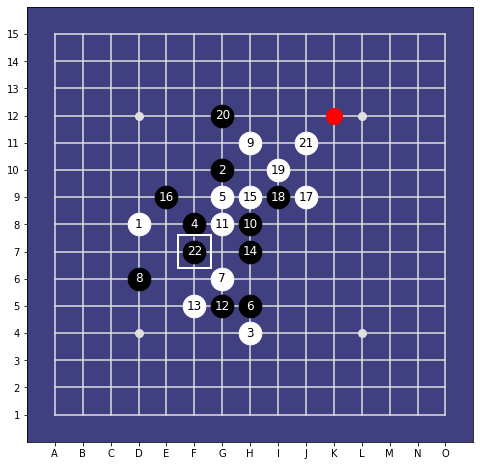

In [92]:
from copy import deepcopy
from domoku.board import GomokuBoard as LegacyBoard
board = deepcopy(board)
stones = board.stones[:-1]
stones = "".join([str(stone) for stone in stones])
board_t = LegacyBoard(n=BOARD_SIZE, disp_width=8, stones=stones, heuristics=policy)
board_t.display()

---

### For reference: The policy's opinion about that board state

In [94]:
board = GomokuBoard(BOARD_SIZE, stones)
pi, v = policy(board.canonical_representation())
print((np.array(pi)*1000).astype(int))
print(f"Value: {v}")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   2 934   0   0   0   0]
 [  0   0   1   0   0   0   2   0   4   0   4   0   0   0   0]
 [  0   0   0   2   0   2   0   0   0   6   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   3   2   0   0   0   0]
 [  0   0   0   0   1   0   4   0   2   0   0   1   0   0   0]
 [  0   0   0   0   0   1   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
Value: 0.9303526098489738


---

### The search tree has a similar yet more ascertive opinion
The action counts will inform the next policy and the $max(Q_a)$ may inform the value function.

In most cases, the softmax will agree with the move actually taken, only if the chances are somewhat equally distributed, will the softmax also allow for a choice.

In [95]:
key = board.get_string_representation()
probs = mcts.compute_probs(board, temperature=1.0)
probs = np.array(probs).reshape([BOARD_SIZE, BOARD_SIZE])
print((probs*100).astype(int))
q_advice = [mcts.Q.get((key, i), -float('inf')) for i in range(225)]
print()
print(f"Value from max(Q): {np.max(q_advice)}")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 100   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

Value from max(Q): 1.0


# Symmetries

In [12]:
math_rep = board.canonical_representation()
symmetries = game.get_symmetries(math_rep, probs)
symmetries[0][0].shape

(17, 17, 3)

We see the board diagonally flipped

In [13]:
gt.print_channels(symmetries[0][0])

shape: (17, 17, 3)
[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 3]
 [3 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


In [14]:
for i in range(1):
    print((np.array(symmetries[i][1]).reshape(15, 15) * 100).astype(int))
    print()

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 91  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]



---

# Training

Would be nice to see the training converge (and overfit) with a single episode in its 8 symmetries, and validate the overfitted against a board with all stones shifted. We'd expect only minor differences due to the different border influence, but otherwise the conv-only network naturally features translation symmetry.

In [5]:
detector = HeuristicPolicy(BOARD_SIZE, cut_off=.1)
game = Gomoku(BOARD_SIZE, detector=detector, initial=initial_stones(BOARD_SIZE, 4))

2022-07-12 22:40:28.307179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 22:40:28.307855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 22:40:28.313332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 22:40:28.314033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 22:40:28.314938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [6]:
params = TrainParams(
    epochs_per_train=500,
    update_threshold=0.6,
    max_queue_length=8192,    # Number of game examples to keep to train the neural networks.
    num_simulations=25,
    arena_compare=2,         # Number of games to play during arena play to evaluate new network.
    cpuct=1.0,
    checkpoint_dir='./temperature/',
    load_model=False,
    load_folder_file=('/dev/models/8x100x50', 'best.pth.tar'),
    num_iters_for_train_examples_history=4,
    num_iterations=2,
    num_episodes=1,
    temperature_threshold=12
)
coach = Coach(game, params=params)

In [7]:
policy = HeuristicPolicy(BOARD_SIZE, cut_off=.1)
mcts = MCTS(game, policy, cpuct=1.0, num_simulations=100, model_threshold=.4)
examples = coach.create_trajectories(mcts, 1, shuffle=False)

   Self Play:   0%|          | 0/1 [00:00<?, ?it/s]2022-07-12 22:40:41.654355: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-12 22:40:41.892318: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
   Self Play: 100%|██████████| 1/1 [01:14<00:00, 74.61s/it]


In [8]:
len(examples)

120

In [9]:
import numpy as np
ex = examples[-1]
print(len(ex), ex[0].shape, ex[2])
print((np.array(ex[1])*100).reshape((15, 15)).astype(int))

3 (17, 17, 3) 1.0
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 100   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [10]:
gt.print_channels(ex[0])

shape: (17, 17, 3)
[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 3]
 [3 0 0 0 0 0 2 0 1 1 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 2 1 1 1 1 2 0 0 0 0 3]
 [3 0 0 0 0 0 0 2 1 2 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


In [11]:
the_model = NeuralNetAdapter(BOARD_SIZE)
the_model.policy.summary()

the_model.train(examples, params)

Model: "gomoku_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 initial (Conv2D)            multiple                  11648     
                                                                 
 potential_0 (Conv2D)        multiple                  123936    
                                                                 
 potential_1 (Conv2D)        multiple                  123936    
                                                                 
 potential_2 (Conv2D)        multiple                  123936    
                                                                 
 potential_3 (Conv2D)        multiple                  123936    
                                                                 
 potential_4 (Conv2D)        multiple                  123936    
                                                                 
 policy_aggregator (Conv2D)  multiple                 

In [12]:
ex=examples[-8]
print(len(ex), ex[0].shape, ex[2])
print((np.array(ex[1]) * 100).reshape((15, 15)).astype(int))
gt.print_channels(ex[0])

3 (17, 17, 3) 1.0
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 100   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
shape: (17, 17, 3)
[[3 3 3 3 3 3 3 3

In [13]:
p, v = the_model.predict(np.expand_dims(ex[0], axis=0).astype(float), debug=True)
print((p*100).numpy().reshape((15, 15)).astype(int))
print()
print(f"Value: {int(v)}")

Potential: 66065.0859375
Value Head: 18.267892837524414
Policy Head: 863.7736206054688
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 99  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]

Value: 18
